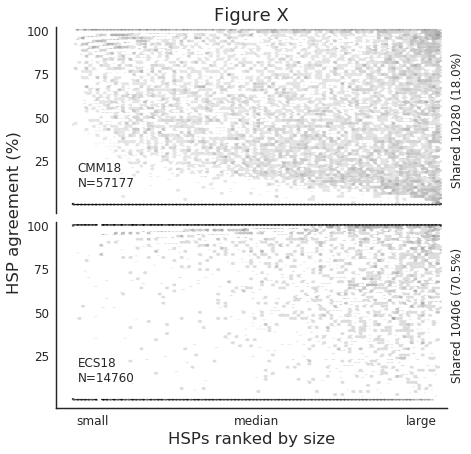

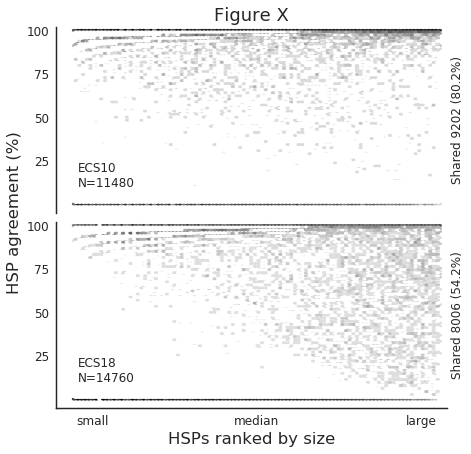

In [39]:
%matplotlib inline

import os as os
import collections as col
import itertools as itt
import pickle as pck
import time as ti
import json as js

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np
import numpy.random as rng
import scipy.stats as stats
import pandas as pd
from pandas.errors import EmptyDataError
import seaborn as sns

# What does this do?
# Plot overlaps among HSP sets as heatmap
# with similarities calculated as Jaccard index

date = '20180611'

run_plot_seg_agreement = True

save_figures = True

sns.set(style='white',
        font_scale=1.5,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

np.seterr('raise')

journal = 'ox_bioinf'
res = 'print_lo'
fig_sizes = js.load(open('/home/pebert/work/code/mpggit/statediff/annotation/misc/fig_sizes.json'))
fig_sizes = fig_sizes[journal]
resolution = fig_sizes['resolution']

scorings = ['emission', 'replicate']
segmentations = ['cmm18', 'ecs18', 'ecs10']

sns.set(style='white',
        font_scale=1.5,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis/projects/statediff'
cache_dir = os.path.join(fhgfs_base, 'caching/notebooks')

data_root = os.path.join(fhgfs_base, 'sciddo', 'deep')
isect_root = os.path.join(fhgfs_base, 'bedtools', 'deep')

base_out = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/statediff'
fig_supp = os.path.join(base_out, 'figures', 'pub', 'supp')
fig_main = os.path.join(base_out, 'figures', 'pub', 'main')
fig_collect = os.path.join(base_out, 'figures', 'pub', 'collection')
                   
    
def collect_hsp_coverage(rootfolder):
    collector = col.Counter()
    for root, dirs, datafiles in os.walk(rootfolder):
        if root.endswith('data_dump'):
            for df in datafiles:
                if df.endswith('.bed') and df.startswith('deep_hg38_'):
                    data = pd.read_csv(os.path.join(root, df), sep='\t', header=0)
                    parts = df.split('.')[0].split('_')
                    seg, c1, c2, score = parts[2], parts[3], parts[5], parts[6].split('-')[1]
                    collector[(c1 + '_vs_' + c2, score, seg)] += int((data['chromEnd'] - data['chromStart']).sum())
    return collector
    

def collect_hsp_overlaps(paths):
    
    collector = col.Counter()
    for path in paths:
        for root, dirs, tables in os.walk(path):
            if tables:
                for t in tables:
                    if t.endswith('.tsv'):
                        file_id1, file_id2 = t.split('.')[0].split('-ovl-')
                        seg1, comp1, score1 = file_id1.split('-')
                        seg2, comp2, score2 = file_id2.split('-')
                        
                        tsv_path = os.path.join(root, t)
                        try:
                            ovl = pd.read_csv(tsv_path, sep='\t', header=None)
                        except EmptyDataError:
                            print('File empty: {}'.format(tsv_path))
                            shared = 0
                        else:
                            shared = int(ovl[ovl.columns[-1]].sum())
                        collector[((comp1, score1, seg1), (comp2, score2, seg2))] += shared
    return collector


def get_all_hsp(seg, score, comp):
    fpath = os.path.join(data_root, seg, 'data_dump', 'deep_hg38_{}_{}_hsp-{}.bed'.format(seg, comp, score))
    df = pd.read_csv(fpath, sep='\t', header=0)
    assert df.shape[0] > 0, 'No HSPs loaded from file: {}'.format(fpath)
    header = ['chrom'] + df.columns[1:].tolist()
    df = df[['name', 'chromStart', 'chromEnd']].copy()
    return df, header


def collect_hsp_agreement(paths, cache_file):
    
    total_hsp = col.Counter()
    header = None
    split_a = ['A_name', 'A_chromStart', 'A_chromEnd', 'overlap']
    split_b = ['B_name', 'B_chromStart', 'B_chromEnd', 'overlap']
    
    subset_columns = ['name', 'length', 'coverage', 'pct_rank_len', 'pct_cov',
                      'chromStart', 'chromEnd', 'group', 'segment', 'scoring']
        
    with pd.HDFStore(cache_file, 'w') as cache:
        for path in paths:
            for tsv in os.listdir(path):
                if not tsv.endswith('.tsv'):
                    continue
                fpath = os.path.join(path, tsv)
                
                seg1, seg2 = tsv.split('.')[0].split('-ovl-')
                seg1, comp1, score1 = seg1.split('-')
                seg2, comp2, score2 = seg2.split('-')

                hsp_a, header = get_all_hsp(seg1, score1, comp1)
                hsp_a.columns = ['name', 'chromStart', 'chromEnd']
                header_a = ['A_' + h for h in header]
                header_b = ['B_' + h for h in header]
                header = header_a + header_b + ['overlap']
                
                hsp_b, _ = get_all_hsp(seg2, score2, comp2)
                hsp_b.columns = ['name', 'chromStart', 'chromEnd']

                df = pd.read_csv(fpath, sep='\t', header=None, names=header)
                
                # handle direction A to B
                shared_a = df[split_a].copy()
                tmp = shared_a.groupby(['A_name', 'A_chromStart', 'A_chromEnd'], as_index=False)['overlap'].sum()
                tmp.columns = ['name', 'chromStart', 'chromEnd', 'coverage']
                tmp['pct_cov'] = tmp['coverage'] / (tmp['chromEnd'] - tmp['chromStart'])
                
                hsp_a = hsp_a.merge(tmp, how='outer', on=['name', 'chromStart', 'chromEnd'], suffixes=('', ''))
                hsp_a.fillna(0, inplace=True)
                hsp_a['group'] = 'A'
                hsp_a['length'] = hsp_a['chromEnd'] - hsp_a['chromStart']
                hsp_a['pct_rank_len'] = hsp_a['length'].rank(pct=True)
                hsp_a['segment'] = seg1
                hsp_a['scoring'] = score1
                                
                # handle direction B to A
                shared_b = df[split_b].copy()
                tmp = shared_b.groupby(['B_name', 'B_chromStart', 'B_chromEnd'], as_index=False)['overlap'].sum()
                tmp.columns = ['name', 'chromStart', 'chromEnd', 'coverage']
                tmp['pct_cov'] = tmp['coverage'] / (tmp['chromEnd'] - tmp['chromStart'])
                
                hsp_b = hsp_b.merge(tmp, how='outer', on=['name', 'chromStart', 'chromEnd'], suffixes=('', ''))
                hsp_b.fillna(0, inplace=True)
                hsp_b['group'] = 'B'
                hsp_b['length'] = hsp_b['chromEnd'] - hsp_b['chromStart']
                hsp_b['pct_rank_len'] = hsp_b['length'].rank(pct=True)
                hsp_b['segment'] = seg2
                hsp_b['scoring'] = score2
                
                df = pd.concat([hsp_a, hsp_b], axis=0, ignore_index=False)
                df = df[subset_columns].copy()
                                
                cov_max = df['pct_cov'].max()
                assert cov_max < 1 or np.isclose(cov_max, 1, atol=1e-6), \
                    'Pct. cov off: {}'.format(df['pct_cov'].max())
                                
                cache_path = os.path.join(seg1, score1, comp1, seg2, score2, comp2)
                cache.put(cache_path, df, format='table')               
    return cache_file


def plot_agreement_scatter(dataset, fkey):
    """
    """
    
    fig, (ax_1, ax_2) = plt.subplots(figsize=fig_sizes['two_col']['square'],
                                     nrows=2, ncols=1, sharex=False, sharey=False,
                                     gridspec_kw={'height_ratios': [1, 1]})
    
    plt.subplots_adjust(hspace=0.05)
    
    colormap = 'binary'
    xlimits = (-0.05, 1.02)
    ylimits = (-0.05, 1.02)
    xticks = [0.05, 0.5, 0.95]
    xticklabels = ['small', 'median', 'large']
    yticks = np.array([0.25, 0.5, 0.75, 1.])
    yticklabels = list(map(str, np.array(yticks * 100, dtype=np.int8)))
    gs = 100
        
    sub_a = dataset.loc[dataset['group'] == 'A', :].copy()
    a_total = sub_a.shape[0]
    a_shared = sub_a.loc[sub_a['pct_cov'] > 0, :].shape[0]
    
    a_label = '{}\nN={}'.format(sub_a.at[0, 'segment'][0].upper(), a_total)
    ay_label = 'Shared {} ({}%)'.format(a_shared, np.round((a_shared / a_total) * 100, 1))
    
    ax_1.hexbin(sub_a['pct_rank_len'], sub_a['pct_cov'],
                cmap=colormap, bins='log', gridsize=gs,
                marginals=False)
    ax_1.set_xlim(xlimits)
    ax_1.set_ylim(ylimits)
    ax_1.spines['right'].set_visible(False)
    ax_1.spines['top'].set_visible(False)
    ax_1.spines['bottom'].set_visible(False)
    ax_1.set_yticks(yticks)
    ax_1.set_yticklabels(yticklabels, fontsize=12)
    ax_1.set_xticks([])
    
    ax_1.text(0.01, 0.1, s=a_label, fontdict={'fontsize': 12})
    
    ax_1y = ax_1.twinx()
    ax_1y.set_ylabel(ay_label, fontsize=12)
    ax_1y.set_yticks([])
    ax_1y.spines['top'].set_visible(False)
    ax_1y.spines['right'].set_visible(False)
    ax_1y.spines['bottom'].set_visible(False)
    
    ylab = ax_1.set_ylabel('HSP agreement (%)')
    ylab.set_position((0, 0))
    ax_1.set_title(fkey)
    
    
    sub_b = dataset.loc[dataset['group'] == 'B', :].copy()
    b_total = sub_b.shape[0]
    b_shared = sub_b.loc[sub_b['pct_cov'] > 0, :].shape[0]
    
    b_label = '{}\nN={}'.format(sub_b.at[0, 'segment'][0].upper(), sub_b.shape[0])
    by_label = 'Shared {} ({}%)'.format(b_shared, np.round((b_shared / b_total) * 100, 1))
        
    ax_2.hexbin(sub_b['pct_rank_len'], sub_b['pct_cov'],
                cmap=colormap, bins='log', gridsize=gs,
                marginals=False)
    ax_2.set_xlim(xlimits)
    ax_2.set_ylim(ylimits)
    ax_2.spines['right'].set_visible(False)
    ax_2.spines['top'].set_visible(False)
    ax_2.set_xticks(xticks)
    ax_2.set_xticklabels(xticklabels, fontsize=12)
    ax_2.set_yticks(yticks)
    ax_2.set_yticklabels(yticklabels, fontsize=12)
    
    ax_2.text(0.01, 0.1, s=b_label, fontdict={'fontsize': 12})
    
    ax_2y = ax_2.twinx()
    ax_2y.set_ylabel(by_label, fontsize=12)
    ax_2y.set_yticks([])
    ax_2y.spines['top'].set_visible(False)
    ax_2y.spines['right'].set_visible(False)
    
    ax_2.set_xlabel('HSPs ranked by size')
        
    return fig, []


def plot_segmentation_agreement():
    isect_files = [os.path.join(isect_root, 'hsp_isect/diff_ident_ident')]
    cache_file = os.path.join(cache_dir, '{}_plot_segagree_scatter.h5'.format(date))
    if not os.path.isfile(cache_file) or os.stat(cache_file).st_size < 5e6:
        _ = collect_hsp_agreement(isect_files, cache_file)
        
    with pd.HDFStore(cache_file, 'r') as hdf:
        cached_keys = list(hdf.keys())
        for s1, s2 in itt.product(['cmm18', 'ecs18', 'ecs10'], repeat=2):
            if s1 == s2:
                continue
            if (s1, s2) not in [('cmm18', 'ecs18'), ('ecs18', 'ecs10')]:
                continue
            for score in ['emission', 'replicate']:
                if score != 'emission':
                    continue
                load_keys = [k for k in cached_keys if all(x in k for x in [s1, s2, score])]
                if not load_keys:
                    continue
                plot_data = []
                for k in load_keys:
                    data = hdf[k]
                    plot_data.append(data)
                plot_data = pd.concat(plot_data, axis=0, ignore_index=False)
                fig, exart = plot_agreement_scatter(plot_data, 'Figure X')
                
                if save_figures:
                    outname = 'fig_X_hsp-agree_{}_{}_{}'.format(s1, s2, score)
                    
                    out_pdf = os.path.join(fig_collect, outname + '.pdf')
                    fig.savefig(out_pdf, bbox_inches='tight', extra_artists=exart)
                    
                    out_png = os.path.join(fig_collect, outname + '.png')
                    fig.savefig(out_png, bbox_inches='tight', extra_artists=exart, dpi=resolution[res])
                
    return



if run_plot_seg_agreement:
    plot_segmentation_agreement()
